---
**Autores**: Prof. João Nogueira e Prof. Dino Magri

**Contato**: `joaonogueira@fisica.ufc.br` e `professor.dinomagri@gmail.com`

**Licença deste notebook**: 
<br>
<img align="left" width="80" src="https://licensebuttons.net/l/by/3.0/88x31.png" />

<br>
<br>

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)


---

## Projeto - Parte 2 - Aprendizagem Supervisionada - Classificação - Exercícios

---
#### NOTA MÁXIMA: 25 pontos

#### NOME COMPLETO: `John S Costa`
--- 
<img align="center" width="150" src="https://logodownload.org/wp-content/uploads/2017/05/ifood-logo-0.png">



## Definição do Problema

O departamento de CRM/Marketing do iFood fez uma solicitação para o time de Ciência de Dados (que estão atrelados ao time de dados dentro da área de TI) para criar um modelo de Machine Learning para prever os clientes que darão Churn.


O objetivo deles com o modelo é atuar sobre os clientes com maiores chances de darem churn no próximo mês.

- A ação será realizada 1 vez por mês, todo dia 01.
- Como a frequência de compras dos clientes do IFood é relativamente alta, então ficou-se decidido na reunião com a área cliente que o modelo seria construído usando features construídas em um período fechado de 1 mês para prever se um dado cliente irá deixar de comprar (churn) no próximo mês. 

A métrica principal de avaliação do modelo é a AUC, dado que o score gerado pelo modelo será usado para ordenar a base.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd


## Lendos os Dados

In [ ]:
df_orders = pd.read_csv('/content/drive/MyDrive/projeto-ia-codigos/projeto-ia-datasets/ifood/orders.csv')

In [ ]:
df_orders.head()

,order_id,order_number,order_timestamp_local,order_shift,last_status_date_local,order_total,credit,paid_amount,delivery_type,scheduled,scheduled_creation_date_local,device_app_version,device_type,device_platform,payment_method,customer_state_label,customer_city,customer_district,customer_centroid_id,customer_has_plus,customer_seg_status_last_month,customer_seg_recency_bucket,customer_seg_frequency_bucket,customer_seg_merchant_offer_bucket,customer_seg_benefits_sensitivity_bucket,customer_seg_marlin_tag,customer_seg_gross_income_bucket,customer_seg_preferred_shift,frn_id,merchant_city,merchant_district,merchant_centroid_id,merchant_dish_type,distance_merchant_customer,promo_is_promotion,normal_items_quantity,promo_items_quantity,order_lag_at_login,order_lead_at_login,order_date_local,valid_order,session_id,customer_id
0,630e2af0-b456-4b3a-b964-4d66ce5cc5df,1290139943,2019-12-11T13:22:06.497Z,weekday lunch,2019-12-11T15:22:39.156Z,28.90,14.0,24.9,DELIVERY,False,2019-12-11T13:22:06.497Z,9.29.1,MOBILE,ANDROID,CC_ONLINE,RN,PARNAMIRIM,NOVA PARNAMIRIM,-5.89-35.2,False,Active,1.0,5.0,5.0,Alta,NaN,6.0,NaN,43583,NATAL,PONTA NEGRA,-5.87-35.18,Comida Brasileira,2722.603906,0.0,2.0,0.0,2.0,1.0,2019-12-11T00:00:00.000Z,1,ccbcf9e2-3728-4458-a813-4031ae22e4bd,48b6d81407646ca61163f064a426ce38ac08bed2ce84f0...
1,66f8163d-f081-4fbd-adb8-cfbbff9213f7,1141271215,2019-11-06T17:57:17.967Z,weekday dinner,2019-11-06T18:18:48.680Z,56.35,7.9,50.4,DELIVERY,False,2019-11-06T17:57:17.967Z,webapp_6.2.0,SITE,DESKTOP,CC_ONLINE,PR,LONDRINA,Gleba Fazenda Palhano,-23.33-51.19,False,Active,1.0,4.0,5.0,Media,1. Marlin,6.0,NaN,533415,LONDRINA,Gleba Fazenda Palhano,-23.34-51.19,Lanches,1108.823183,1.0,0.0,1.0,7.0,1.0,2019-11-06T00:00:00.000Z,1,d9e94d88-ca88-4997-ad4c-62b9c0a35c1b,b3f74186880f5f9a79e0865ad8beab47e22b785b8b3bc0...
2,e8c55557-81d4-4159-bd2b-c144e5fbabe3,694742752,2019-06-11T20:42:32.058Z,weekday dinner,2019-06-11T22:42:54.005Z,53.80,4.0,49.8,DELIVERY,False,2019-06-11T20:42:32.058Z,iOS_iFood_9.2.1,MOBILE,IOS,CC_ONLINE,SP,SAO PAULO,Jardim Santa Cruz (sacoma),-23.64-46.59,NaN,Active,1.0,5.0,5.0,Media,1. Marlin,6.0,5. Jantar,166370,SAO PAULO,Parque Bristol,-23.64-46.61,Comida Brasileira,1642.258522,0.0,2.0,0.0,5.0,1.0,2019-06-11T00:00:00.000Z,1,035b33cd-6ddf-4ee2-a887-7ba490bb9700,c4f8999d4cb83cac8134b2051ffc611d5d660c049c3744...
3,34a60e0d-0042-49af-9aa8-4dc526a998c2,679245732,2019-06-05T19:16:42.111Z,weekday dinner,2019-06-05T21:17:13.264Z,58.90,4.0,54.9,DELIVERY,False,2019-06-05T19:16:42.111Z,iOS_iFood_9.2.1,MOBILE,IOS,CC_ONLINE,PR,LONDRINA,Centro,-23.31-51.17,NaN,Active,1.0,4.0,5.0,Media,1. Marlin,6.0,5. Jantar,178646,LONDRINA,Centro,-23.31-51.17,Lanches,441.677507,0.0,1.0,0.0,9.0,2.0,2019-06-05T00:00:00.000Z,1,93f66506-a8ba-4c22-97ea-7489131958bb,ac89a3eb35853705a09d54f1e5988ad876628b986045cd...
4,998f6d97-f884-40ba-a7a3-e9691930a642,1052187003,2019-10-15T21:01:23.973Z,weekday dinner,2019-10-15T23:01:41.146Z,54.80,14.0,50.8,DELIVERY,False,2019-10-15T21:01:23.973Z,Android_iFood_9.22.1,MOBILE,ANDROID,CC_ONLINE,SP,SAO PAULO,Parque Panamericano,-23.45-46.73,False,Active,2.0,4.0,4.0,Media,1. Marlin,6.0,NaN,77662,SAO PAULO,Jardim Santo Elias,-23.48-46.74,Comida Japonesa,4398.730930,1.0,0.0,2.0,3.0,4.0,2019-10-15T00:00:00.000Z,1,515a402d-8b86-4e6d-9852-f02282736781,fdef6bf0530b1f6507f175167aa442ade79b6e6fa085c9...


## Análise Exploratória (1 ponto)

**<span style="color:blue">(0.25 ponto)</span> `Q1`** Quantas linhas e colunas existem na base `df_orders`?

In [ ]:
print("possui " + str(df_orders.shape[0]) + " linhas \n" +"E "+str(df_orders.shape[1]) + " colunas")


possui 492138 linhas 
E 43 colunas


**<span style="color:blue">(0.25 ponto)</span> `Q2`** Verifique se todos os pedidos são unicos.

In [ ]:
df_orders.order_id.nunique()

492138

**<span style="color:blue">(0.25 ponto)</span> `Q3`** Qual o pedido mais antigo e o mais recente da base? Utilize a variável `order_timestamp_local`.

In [ ]:
dt_min = df_orders.order_timestamp_local.min()
dt_max = df_orders.order_timestamp_local.max()

df_resp = (
    df_orders[['order_id', 'order_timestamp_local']]
    .query("order_timestamp_local == "+"'"+str(dt_min)+"'"+ "or order_timestamp_local == "+"'"+str(dt_max)+"'")
    .reset_index()
)
df_resp.head()

,index,order_id,order_timestamp_local
0,176604,71b5ce4c-6ca5-4f96-9d85-ed6a2cdac4fe,2019-12-31T23:31:59.972Z
1,482261,afe5e13a-d74b-4e6e-9ffa-4e7eaecf6ae4,2019-06-01T00:00:15.369Z


**<span style="color:blue">(0.25 ponto)</span> `Q4`** Quantos usuários únicos existem na base?

In [ ]:
df_orders.customer_id.nunique()

30079

## Criação da ABT (10 pontos)

Será que variáveis como Recência, Frequência e Valor podem nos ajudar a prever se um dado cliente irá realizar um novo pedido no próximo mês?

Vamos criar variáveis que descrevem o comportamento do cliente com base em 1 mês e usar essas variáveis para prever se o cliente irá comprar no próximo mês (caso em que acontecerá um churn e talvez seja interessante oferecermos um cupom de desconto através de notificações no app).

**<span style="color:blue">(1.0 ponto)</span> `Q5`** Crie um DataFrame chamado `df_features_train` que deverá conter os dados do período 2019-06-01 (inclusivo) até 2019-07-01 (exclusivo), ou seja deve conter somente os dados referente ao mês 6.

In [ ]:
df_features_train = (
    df_orders
    .query("order_date_local >= '2019-06-01' and order_date_local < '2019-07-01'")
    .reset_index()
)

**<span style="color:blue">(1.0 ponto)</span> `Q6`** Crie um DataFrame chamado `df_target_train` que deverá conter os dados do período 2019-07-01 (inclusivo) até 2019-08-01 (exclusivo), ou seja deve conter somente os dados referente ao mês 7.

Depois selecione apenas a coluna `customer_id` e remova os duplicados.

In [ ]:
df_target_train = (
    df_orders
    .query("order_date_local >= '2019-07-01' and order_date_local < '2019-08-01'")
    .reset_index()
)

df_target_train = df_target_train['customer_id']
df_target_train = df_target_train.drop_duplicates()

**<span style="color:blue">(2.0 ponto)</span> `Q7`** Faça o agrupamento no DataFrame `df_features_train` pela feature `customer_id`. Faça as agregações abaixo, renomeando o resultado para as seguintes colunas `receita_1m`, `qtde_pedidos_1m` e `data_ultima_venda`, respectivamente.

- 'paid_amount' - 'sum'
- 'order_id' - 'nunique'
- 'order_timestamp_local' - 'max'

Lembre-se de utilizar o conceito que vimos em sala para renomear o resultado da agregação.

Também utilize o método `reset_index` para reinicar os indices.

Salve na variável `df_abt_train`.

In [ ]:
df_abt_train = (
    df_features_train
  .groupby(['customer_id'])
  .agg( 
          receita_1m = ('paid_amount','sum'),
          qtd_pedidos_1m = ('order_id','nunique'),
          data_ultima_venda = ('order_timestamp_local','max'),
       )
  .reset_index()
)

**<span style="color:blue">(3.0 pontos)</span> `Q8`** Utilize o método `.assign` do DataFrame para fazer as seguintes alterações:

- Altere o tipo da coluna `data_ultima_venda` para o formato de data utilizando o comando `pd.to_datetime` com o parâmetro `utc=True`.
- Crie uma nova coluna chamada `data_ref` com o valor de `2019-07-01` e faça a converção utilizando o comando `pd.to_datetime` com o parâmetro `utc=True`
- Crie uma nova coluna chamada `recencia` e salve os dias referentes a subtração da coluna `data_ref` e `data_ultima_venda`. Lembre-se de extrair os dias (`.dt.days`)
- Por fim, selecione apenas as seguintes colunas: `['data_ref', 'customer_id', 'receita_1m', 'qtd_pedidos_1m', 'recencia']`

O resultado dessas alterações devem ser salvas na variável `df_abt_train`


In [ ]:
df_abt_train = (
    df_abt_train
    .assign(data_ultima_venda = pd.to_datetime(df_abt_train.data_ultima_venda, utc=True))
    .assign(data_ref = pd.to_datetime('2019-07-01',utc=True))
    .assign(recencia = lambda df_abt_train: (df_abt_train['data_ref'] - df_abt_train['data_ultima_venda']).dt.days)
    .filter(items=['data_ref', 'customer_id', 'receita_1m', 'qtd_pedidos_1m', 'recencia'])
    .reset_index()
)

**<span style="color:blue">(1.0 pontos)</span> `Q9`** Faça o `merge` com o DataFrame `df_abt_train` com o `df_target_train` com os seguintes parametros:

- `how='left'`
- `on='customer_id'`
- `indicator=True`

Salve o merge na variável `df_abt_train`.


In [ ]:
df_target_train = pd.DataFrame(df_target_train)

In [ ]:
df_abt_train = (
   df_abt_train
    .merge(df_target_train, on='customer_id', how='left', indicator=True)
    .reset_index()
)

**<span style="color:blue">(1.0 pontos)</span> `Q10`** Utilize o método `.assign` para criar a coluna `churn_next_month`.

Utilize a função `np.where` para fazer a criação. Compare as colunas `_merge` com `left_only`, se ambas forem iguais, o resultado deve ser 1, caso contrário deve ser 0.

* Obs: não esquecer de dropar a coluna `_merge` depois de ter criado a variável target.

In [ ]:
df_abt_train = (
    df_abt_train
    .assign(churn_next_month = (np.where(df_abt_train['_merge']=='left_only',1,0)))
    .drop(columns=['_merge'])
    .filter(['data_ref','customer_id','receita_1m','qtd_pedidos_1m','recencia','churn_next_month'])
    .reset_index()
)

**<span style="color:blue">(1.0 pontos)</span> `Q11`** Verifique a distribuição da coluna `churn`.

In [ ]:
df_abt_train.head(5)

,index,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month
0,0,2019-07-01 00:00:00+00:00,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,15,1
1,1,2019-07-01 00:00:00+00:00,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,19,1
2,2,2019-07-01 00:00:00+00:00,0004720dc16aed1f98fd79f59736170e0d686199cd9ae5...,59.3,1,29,1
3,3,2019-07-01 00:00:00+00:00,0006a32816a3af172048de7db87c97c4c8c7ad7e6385fa...,95.2,2,1,1
4,4,2019-07-01 00:00:00+00:00,00081913eb21cd12aecc831bda704f8c6482723b55e664...,27.0,1,13,1


In [ ]:
(
    df_abt_train
    .groupby(['data_ref'])
    .agg(idx = ('churn_next_month','mean'))
)

,idx
data_ref,
2019-07-01 00:00:00+00:00,0.386914


<img align="left" width="20" src="http://dinomagri.com/imgs/checkpoint.png" /> &nbsp; **CHECKPOINT** - O DataFrame `df_abt_train` deverá conter exatamente `(30079, 6)`. E a distribuição da variável target deve ser `0.613086` para não-churn (0) e `0.386914` para churn (1).

# Modelagem (14 pontos)

**<span style="color:blue">(2 pontos)</span> `Q12`** Crie uma ABT Out of Time avançando 1 mês no código anterior. Porque devemos criar uma ABT Out of Time?

Utilize o mês 08 para criar essa ABT.

In [ ]:
import dateutil

df_abt_safras = pd.DataFrame()
for safra in ['2019-07-01','2019-08-01']:
    data_ref_safra     = pd.to_datetime(safra).date()
    data_feat_inclusiva = data_ref_safra - dateutil.relativedelta.relativedelta(months=1)
    data_feat_exclusiva = pd.to_datetime(safra).date()
    data_inf_inclusiva  = pd.to_datetime(safra).date()
    data_sup_exclusiva  =  pd.to_datetime(safra).date() + dateutil.relativedelta.relativedelta(months=1)
    
    
    #TARGET-----------------------------------------------
    df_features_train_ = (
    df_orders
    .query(f"order_date_local >= '{data_feat_inclusiva}' and order_date_local < '{data_feat_exclusiva}'")
    .reset_index()
    )
    
    #TARGET-----------------------------------------------
    df_target_train_ = (
      df_orders
      .query(f"order_date_local >= '{data_inf_inclusiva}' and order_date_local < '{data_sup_exclusiva}'")
      .reset_index()
    )
    df_target_train_ = df_target_train_['customer_id']
    df_target_train_ = df_target_train_.drop_duplicates()


    #ABT_TRAIN-----------------------------------------------
    df_abt_train_ = (
    df_features_train_
      .groupby(['customer_id'])
      .agg( 
              receita_1m = ('paid_amount','sum'),
              qtd_pedidos_1m = ('order_id','nunique'),
              data_ultima_venda = ('order_timestamp_local','max'),
          )
      .reset_index()
    )


    #ABT_TRAIN-----------------------------------------------
    df_abt_train_ = (
      df_abt_train_
      .assign(data_ultima_venda = pd.to_datetime(df_abt_train_.data_ultima_venda, utc=True))
      .assign(data_ref = pd.to_datetime(f'{data_ref_safra}',utc=True))
      .assign(recencia = lambda df_abt_train_: (df_abt_train_['data_ref'] - df_abt_train_['data_ultima_venda']).dt.days)
      .filter(items=['data_ref', 'customer_id', 'receita_1m', 'qtd_pedidos_1m', 'recencia'])
      .reset_index()
    )
    df_target_train_ = pd.DataFrame(df_target_train_)

    #ABT_TRAIN-----------------------------------------------
    df_abt_train_ = (
      df_abt_train_
        .merge(df_target_train_, on='customer_id', how='left', indicator=True)
        .reset_index()
      )
    #ABT_TRAIN-----------------------------------------------
    df_abt_train_ = (
      df_abt_train_
      .assign(churn_next_month = (np.where(df_abt_train_['_merge']=='left_only',1,0)))
      .drop(columns=['_merge'])
      .filter(['data_ref','customer_id','receita_1m','qtd_pedidos_1m','recencia','churn_next_month'])
      .reset_index()
      )
    

    #ADICINA BASE---------------------------------------------
    df_abt_safras = pd.concat([df_abt_safras, df_abt_train_])


In [ ]:
(
    df_abt_safras
    .groupby('data_ref')
    .agg(propor = ('churn_next_month', 'mean'))
)

,propor
data_ref,
2019-07-01 00:00:00+00:00,0.386914
2019-08-01 00:00:00+00:00,0.240442


<img align="left" width="20" src="http://dinomagri.com/imgs/checkpoint.png" /> &nbsp; **CHECKPOINT** - O DataFrame `df_abt_oot` deverá conter exatamente `(18441, 6)`. E a distribuição da variável target deve ser `0.759558` para não-churn (0) e `0.240442` para churn (1).

**<span style="color:blue">(1 ponto)</span> `Q13`** Faça um estudo de valores faltantes tanto na `df_abt_train` e `df_abt_oot`. 

In [ ]:
df_abt_safras.isnull().sum()


index               0
data_ref            0
customer_id         0
receita_1m          0
qtd_pedidos_1m      0
recencia            0
churn_next_month    0
dtype: int64

**<span style="color:blue">(1 ponto)</span> `Q14`**  Treine uma árvore de decisão na base de treino usando Stratified K-Fold e avalie utilizando a métrica **AUC** na base Out of Time.

Utilize o parametro `random_state=42`

In [ ]:
!pip install feature-engine==1.0.2

     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 9.5MB 361kB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from feature_engine.imputation import ArbitraryNumberImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


# Utilize as seguintes variáveis:
target = 'churn_next_month'

key_vars = ['data_ref', 'customer_id']
num_vars = ['receita_1m', 'qtd_pedidos_1m', 'recencia']
cat_vars = [] # não temos variáveis categóricas
features = num_vars + cat_vars

# Adicione seu código aqui

baseTreino = df_abt_safras.query("data_ref == '2019-07-01'")
baseTeste_oot = df_abt_safras.query("data_ref == '2019-08-01'")
#Base de Treino
x_train = baseTreino[features]
y_train = baseTreino[target]

#Base de Teste
x_test_oot = baseTeste_oot[features]
y_teste_oot = baseTeste_oot[target]

In [ ]:
#Treinando o Modelo
tree_model = Pipeline(steps=[
                             ('numeric_imputer',ArbitraryNumberImputer(variables=num_vars,arbitrary_number=-999)),
                             ('model',DecisionTreeClassifier(random_state=42))
])

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
cv_results = cross_validate(estimator = tree_model, X = x_train, y = y_train, scoring=['roc_auc'], cv = skf, n_jobs=-1)
tree_model_results = pd.DataFrame(cv_results)

In [ ]:
tree_model_results


,fit_time,score_time,test_roc_auc
0,0.121128,0.009750,0.614003
1,0.123578,0.010764,0.605083
2,0.127712,0.008704,0.601329
3,0.118637,0.009795,0.633027
4,0.092605,0.007028,0.620293


In [ ]:
tree_model_results.mean()

fit_time        0.116732
score_time      0.009208
test_roc_auc    0.614747
dtype: float64

In [ ]:
# Avaliando utilizando a métrica AUC na base Out of Time.
from sklearn.metrics import roc_auc_score
#Build a decision tree classifier from the training set (X, y).
tree_model.fit(x_train,y_train)

#Predict class or regression value for X.
y_pred_oot = tree_model.predict(x_test_oot)

#Predict class probabilities of the input samples X.
y_proba_oot = tree_model.predict_proba(x_test_oot)[:,1]

#Metrica roc uac
roc_uac_oot = roc_auc_score(y_teste_oot, y_proba_oot)
print(f"ROC_AUC: {roc_uac_oot:.3f}")


ROC_AUC: 0.594


**<span style="color:blue">(1 ponto)</span> `Q15`** Treine uma Random Forest na base de treino usando Stratified K-Fold e avalie utilizando a métrica **AUC** na base Out of Time.

Utilize o parametro `random_state=42`

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rdf_model = Pipeline(steps=[
                            ('numeric_imputer', ArbitraryNumberImputer(variables = num_vars, arbitrary_number=-999)),
                            ('model', RandomForestClassifier(random_state=42))
])
#cross validation
cv_results = cross_validate(estimator=rdf_model, X=x_train, y=y_train, scoring=['roc_auc'], cv=skf, n_jobs=-1 )
rdf_modelo_results = pd.DataFrame(cv_results)

In [ ]:
rdf_modelo_results

,fit_time,score_time,test_roc_auc
0,4.144639,0.269040,0.679016
1,4.079612,0.263815,0.672089
2,3.899686,0.271555,0.667018
3,3.934866,0.270922,0.689450
4,2.510823,0.209808,0.681063


In [ ]:
rdf_modelo_results.mean()

fit_time        3.713925
score_time      0.257028
test_roc_auc    0.677727
dtype: float64

In [ ]:
# Avaliando utilizando a métrica AUC na base Out of Time.
from sklearn.metrics import roc_auc_score
#Build a decision tree classifier from the training set (X, y).

rdf_model.fit(x_train,y_train)

#Predict class or regression value for X.
y_pred_oot = rdf_model.predict(x_test_oot)

#Predict class probabilities of the input samples X.
y_proba_oot = rdf_model.predict_proba(x_test_oot)[:,1]

#Metrica roc uac
roc_uac_oot = roc_auc_score(y_teste_oot, y_proba_oot)
print(f"ROC_AUC: {roc_uac_oot:.3f}")
print("A ROC obtida ")


ROC_AUC: 0.663
A ROC obtida 


**<span style="color:blue">(1 ponto)</span> `Q16`** Treine um LGBM na base de treino usando Stratified K-Fold e avalie utilizando a métrica **AUC** na base Out of Time.

In [ ]:
from lightgbm import LGBMClassifier

lgbm_model = Pipeline(steps=[
                             ('numeric_imputer',ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
                             ('model', LGBMClassifier(random_state=42))])
cv_results = cross_validate(estimator=lgbm_model, X=x_train, y=y_train, scoring=['roc_auc'], cv = skf, n_jobs=-1)
lgbm_model_results = pd.DataFrame(cv_results)

In [ ]:
lgbm_model_results

,fit_time,score_time,test_roc_auc
0,0.392380,0.071658,0.750741
1,0.353570,0.051471,0.752896
2,0.360494,0.050089,0.743856
3,0.361822,0.054233,0.759458
4,0.238266,0.036688,0.753062


In [ ]:
lgbm_model_results.mean()

fit_time        0.341307
score_time      0.052828
test_roc_auc    0.752003
dtype: float64

In [ ]:
# Avaliando utilizando a métrica AUC na base Out of Time.
from sklearn.metrics import roc_auc_score
#Build a decision tree classifier from the training set (X, y).

lgbm_model.fit(x_train,y_train)

#Predict class or regression value for X.
y_pred_oot = lgbm_model.predict(x_test_oot)

#Predict class probabilities of the input samples X.
y_proba_oot = lgbm_model.predict_proba(x_test_oot)[:,1]

#Metrica roc uac
roc_uac_oot = roc_auc_score(y_teste_oot, y_proba_oot)
print(f"ROC_AUC: {roc_uac_oot:.3f}")
print("A ROC obtida ")


ROC_AUC: 0.733
A ROC obtida 


**<span style="color:blue">(1 ponto)</span> `Q17`** Para o melhor algoritmo dos 3 treinados anteriormente (lightgbm), faça um GridSearch para encontrar um conjunto de hiperparâmetros mais otimizado (lembre de otimizar a **AUC**).

Utilize os seguintes hiperparâmetros:

    'lgbm__max_depth': [3, 5, 7, 9],
    'lgbm__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'lgbm__n_estimators': [100, 300, 500]

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_parm = {
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
    'model__n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(estimator=lgbm_model, param_grid=grid_parm, scoring='roc_auc', cv=skf, n_jobs=-1, refit=True, verbose=1)


In [ ]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('numeric_imputer',
                                        ArbitraryNumberImputer(arbitrary_number=-999,
                                                               imputer_dict=None,
                                                               variables=['receita_1m',
                                                                          'qtd_pedidos_1m',
                                                                          'recencia'])),
                                       ('model',
                                        LGBMClassifier(boosting_type='gbdt',
                                                       class_weight=None,
                                                       colsample_bytree=1.0,
                                                       im...
               

In [ ]:
# Recupere o melhor AUC
best_score = grid_search.best_score_
best_score

0.7568980823018885

In [ ]:
# Recupere os hiperparâmetros
best_paramns = grid_search.best_params_
best_paramns

{'model__learning_rate': 0.05,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [ ]:
# avaliando a performando do melhor modelo no grid search na base oot
best_lgbm_model = grid_search.best_estimator_

best_lgbm_model.fit(x_train, y_train)

y_pred_oot = best_lgbm_model.predict(x_test_oot)
y_proba_oot = best_lgbm_model.predict_proba(x_test_oot)[:,1]

from sklearn.metrics import roc_auc_score

roc_auc_oot = roc_auc_score(y_teste_oot, y_proba_oot)
print(f"ROC-AUC: {roc_auc_oot:.3f}")


ROC-AUC: 0.737


Melhoramos a nossa performance com um grid search bem simples! Muito bom! 

Talvez ainda haja espaço para melhorias na performance do modelo. Lembrando que temos apenas 3 variáveis: `receita_1m`, `qtd_pedidos_1m` e `recencia`. 

Vamos utilizar a variável `order_shift` para criar mais 10 features para verificar se isso irá ajudar o modelo de Machine Learning a predizer qual cliente irá dar **churn**.

**<span style="color:blue">(1 ponto)</span> `Q18`** Utilize o método `pd.crosstab` com o parâmetro `normalize='index'` nas colunas `customer_id` e `order_shift`. Lembre-se de resetar o indíce.

Salve o resultado no DataFrame `df_customer_order_shift_train`.

Imprima os 5 primeiros elementos desse DataFrame.

In [ ]:
df_order_shift_train = pd.crosstab(df_features_train['customer_id'],df_features_train['order_shift'],normalize="index").reset_index()
df_order_shift_train.head(5)

order_shift,customer_id,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0
1,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004720dc16aed1f98fd79f59736170e0d686199cd9ae5...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0006a32816a3af172048de7db87c97c4c8c7ad7e6385fa...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
4,00081913eb21cd12aecc831bda704f8c6482723b55e664...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**<span style="color:blue">(1 ponto)</span> `Q19`** Faça o merge com a `df_abt_train` com os seguintes parâmetros:

- `how='left'`
- `on='customer_id'`

Salve o DataFrame resultante na mesma variável `df_abt_train`.

Imprima as 5 primeiras linhas.

In [ ]:
df_abt_train_new = (
    baseTreino
    .merge(df_order_shift_train, on='customer_id', how='left',)
)
df_abt_train_new.head()

,index,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,0,2019-07-01 00:00:00+00:00,0001a8e61d8b08ad436e8e6f4adeb399b88df962c72d9d...,102.0,2,15,1,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0
1,1,2019-07-01 00:00:00+00:00,0001a9f97d01d2696cf70c7657ee2d039388d691720ff9...,52.0,1,19,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2019-07-01 00:00:00+00:00,0004720dc16aed1f98fd79f59736170e0d686199cd9ae5...,59.3,1,29,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,2019-07-01 00:00:00+00:00,0006a32816a3af172048de7db87c97c4c8c7ad7e6385fa...,95.2,2,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
4,4,2019-07-01 00:00:00+00:00,00081913eb21cd12aecc831bda704f8c6482723b55e664...,27.0,1,13,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**<span style="color:blue">(1 ponto)</span> `Q20`** Replique essas duas etapas para a base de OOT.

- Crie o DataFrame `df_customer_order_shift_oot` utilizando o comando `pd.crosstab` com o parâmetro `normalize='index'`. Lembre-se de resetar o indice.

- Faça o merge com a `df_abt_oot` com os parâmetros `how='left'` e `on='customer_id'`.

- Imprime as 5 primeiras linhas do `df_abt_oot`.


In [ ]:
df_abt_oot_new  = (
    baseTeste_oot
    .merge(df_order_shift_train, on='customer_id', how='left')
    .reset_index()
)
df_abt_oot_new.head()

,level_0,index,data_ref,customer_id,receita_1m,qtd_pedidos_1m,recencia,churn_next_month,weekday breakfast,weekday dawn,weekday dinner,weekday lunch,weekday snack,weekend breakfast,weekend dawn,weekend dinner,weekend lunch,weekend snack
0,0,0,2019-08-01 00:00:00+00:00,000a1fac4f7a67cc3f2e7667167597cb2c9a1b9edafe18...,85.89,3,11,0,0.0,0.0,0.250000,0.000000,0.25,0.0,0.0,0.250000,0.250000,0.0
1,1,1,2019-08-01 00:00:00+00:00,0014b7013c66a05d0b5ce0687d614ac220d3ae1af398d2...,211.96,5,11,0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.0,1.000000,0.000000,0.0
2,2,2,2019-08-01 00:00:00+00:00,00150a9d8edc32b5ac2c1a8089e5615dbd297cea2c6cba...,164.60,2,14,0,0.0,0.0,0.666667,0.000000,0.00,0.0,0.0,0.333333,0.000000,0.0
3,3,3,2019-08-01 00:00:00+00:00,00197c67cab97917c3e147877fc36ae9e9208f4bd578ca...,196.20,5,2,0,0.0,0.0,1.000000,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0
4,4,4,2019-08-01 00:00:00+00:00,001b8d424e1aa9b762831ccce74a6b4c648a83f2d8a239...,238.68,8,0,0,0.0,0.0,0.111111,0.111111,0.00,0.0,0.0,0.333333,0.444444,0.0


Criamos mais 10 variáveis tanto na ABT de treino quanto na de teste (OOT). Essas variáveis indicam o percentual de pedidos realizados por cada usuário em um horário específico do dia.

- weekday breakfast
- weekday dawn
- weekday dinner
- weekday lunch
- weekday snack
- weekend breakfast
- weekend dawn
- weekend dinner
- weekend lunch
- weekend snack

In [ ]:
df_abt_train_new.shape, df_abt_oot_new.shape

((30079, 17), (18441, 18))

**<span style="color:blue">(1 ponto)</span> `Q21`** Temos 13 features, e talvez algumas delas não possuam valor preditivo. Utilize o melhor algoritmo testado até agora, treine e avalie utilizando a métrica **AUC**.

In [ ]:
# Utilize as seguintes variáveis:
target = 'churn_next_month'
num_vars = ['receita_1m', 'qtd_pedidos_1m', 'recencia', 
            'weekday breakfast', 'weekday dawn', 'weekday dinner', 'weekday lunch', 'weekday snack',
            'weekend breakfast', 'weekend dawn', 'weekend dinner', 'weekend lunch', 'weekend snack']
cat_vars = []
features = num_vars + cat_vars

# Adicione seu código aqui

#base de treino
X_train = df_abt_train_new[features]
y_train = df_abt_train_new[target]

#base de teste
X_oot = df_abt_oot_new[features]
y_oot = df_abt_oot_new[target]

# Criando o Pipeline
lgbm_model_order_shift = Pipeline(steps=[
                                         ('numeric_imputer',ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)),
                                         ('model', LGBMClassifier(random_state=42,learning_rate=0.05,max_depth=3, n_estimators=100))
])
cv_results = cross_validate(estimator=lgbm_model_order_shift, X = X_train, y = y_train, scoring=['roc_auc'], cv=skf, n_jobs=-1)
lgbm_model_order_shift_results = pd.DataFrame(cv_results)


In [ ]:
lgbm_model_order_shift_results

,fit_time,score_time,test_roc_auc
0,0.387283,0.042045,0.755979
1,0.385357,0.051568,0.759921
2,0.386254,0.050267,0.751498
3,0.391975,0.051526,0.766379
4,0.256446,0.030140,0.758279


In [ ]:
lgbm_model_order_shift_results.mean()

fit_time        0.361463
score_time      0.045109
test_roc_auc    0.758411
dtype: float64

In [ ]:
# Avaliando a performance do melhor modelo na base oot

lgbm_model_order_shift.fit(X_train, y_train)

y_pred_oot = lgbm_model_order_shift.predict(X_oot)
y_proba_oot = lgbm_model_order_shift.predict_proba(X_oot)[:,1]

from sklearn.metrics import roc_auc_score

roc_uac_oot = roc_auc_score(y_oot, y_proba_oot)
print(f"ROC-AUC: {roc_auc_oot:.3f}")




ROC-AUC: 0.737


**<span style="color:blue">(1 ponto)</span> `Q22`** Houve melhora em relação ao modelo anterior?

In [ ]:
#Não houve melhora significativa

**<span style="color:blue">(1 ponto)</span> `Q23`** Qual foi o melhor modelo encontrado e quais as features utilizadas?

In [ ]:
# O Melhor modelo encontrado foi o LGBM com as features 'receita_1m', 'qtde_pedidos_1m' e 'recencia'

**<span style="color:blue">(1 ponto)</span> `Q24`** Rode o shap values para entender quais as variáveis mais importantes do modelo e como elas se relacionam com a variável target (código já está disponível, basta apenas executar e interpretar para responder as perguntas abaixo).

**Responda:**

- **Qual a variável mais importante?** 
- **Como ela se relaciona com a variável target?** 
- **Como as outras variáveis se relacionam com a variável target?**

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 4.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491638 sha256=da2853e7c483526e2379a815c06ab17c9465b420ab0406221c4d69aec9dc6013
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
features = ['receita_1m', 'qtd_pedidos_1m', 'recencia']

X_train = df_abt_train_new[features]
X_oot   = df_abt_oot_new[features]

In [ ]:
best_lgbm_model

Pipeline(memory=None,
         steps=[('numeric_imputer',
                 ArbitraryNumberImputer(arbitrary_number=-999,
                                        imputer_dict=None,
                                        variables=['receita_1m',
                                                   'qtd_pedidos_1m',
                                                   'recencia'])),
                ('model',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.05, max_depth=3,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None, random_state=42,
                                reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_b

In [ ]:
import shap
explainer = shap.TreeExplainer(best_lgbm_model[-1])

In [ ]:
X_oot_transformado = best_lgbm_model[:-1].transform(X_oot)

In [ ]:
shap_values = explainer.shap_values(X_oot_transformado)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


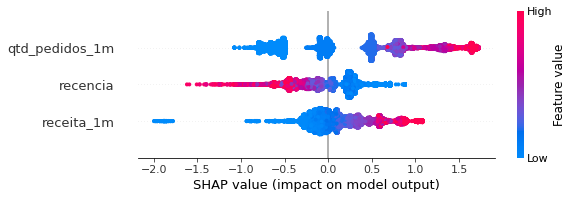

In [ ]:
shap.summary_plot(shap_values[0], X_oot_transformado, plot_type='dot')

**Qual a variável mais importante?**
Qtd_pedidos_1m




**Como ela se relaciona com a variável target?**
quanto maior a quantidade de pedidos, maior impacto positivo na variável resposta, ou seja, quanto maior a quantidade de pedidos no último mês, maior a chance dele não comprar no mês atual

**Como as outras variáveis se relacionam com a variável target?**


*   **Recencia**: Quanto menor a recencia, maior a chance dele não compar no mês atual
*   **Receita_1m**: Quanto maior a receita_1m maior a chance dele não comprar no mês atual

